## About the dataset:

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. 
The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.
The authors of Fashion-MNIST intended the dataset to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. 
Each example is a 28x28 grayscale image, associated with a label from 10 classes. It shares the same image size and structure of training and testing splits.Each training and test example is assigned to one of the following labels:

Label	Description:
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

In the Dataset, each class takes three-rows. 

## 1. Import Libraries/Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 3 (delta 0), pack-reused 758
Receiving objects: 100% (762/762), 105.85 MiB | 54.09 MiB/s, done.
Resolving deltas: 100% (444/444), done.


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/fashion-mnist/data/fashion'

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/fashion-mnist/data/fashion'
/content


In [ ]:
ls

drive/  fashion-mnist/  sample_data/


#### 1.1. Import the required libraries and the dataset (use Google Drive if required).

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import torch

# TensorFlow and tf.keras
import tensorflow as tf


In [ ]:
# training data import
with gzip.open('fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz','rb') as trlab:
  train_labels = np.frombuffer(trlab.read(), dtype=np.uint8,  offset=8)

with gzip.open('fashion-mnist/data/fashion/train-images-idx3-ubyte.gz','rb') as trimg:
  train_images = np.frombuffer(trimg.read(), dtype=np.uint8,  offset=16).reshape(len(train_labels), 28, 28, 1)

# testing data import
with gzip.open('fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz','rb') as tstlab:
  test_labels = np.frombuffer(tstlab.read(), dtype=np.uint8,  offset=8)

with gzip.open('fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz','rb') as tstimg:
  test_images = np.frombuffer(tstimg.read(), dtype=np.uint8,  offset=16).reshape(len(test_labels), 28, 28, 1)

# setting data labels (see top description)
label = ['T-shirt/top',  'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']




Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way.Scaling the image reduces bias:

In [ ]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [ ]:
test_images.shape

(10000, 28, 28, 1)

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
len(label)

10

1.2. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [ ]:
torch.cuda.is_available()


True

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8200
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.843721216


GPU test done!

## 2.Data Visualization and augmentation (1 mark)

#### 2.1 Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).

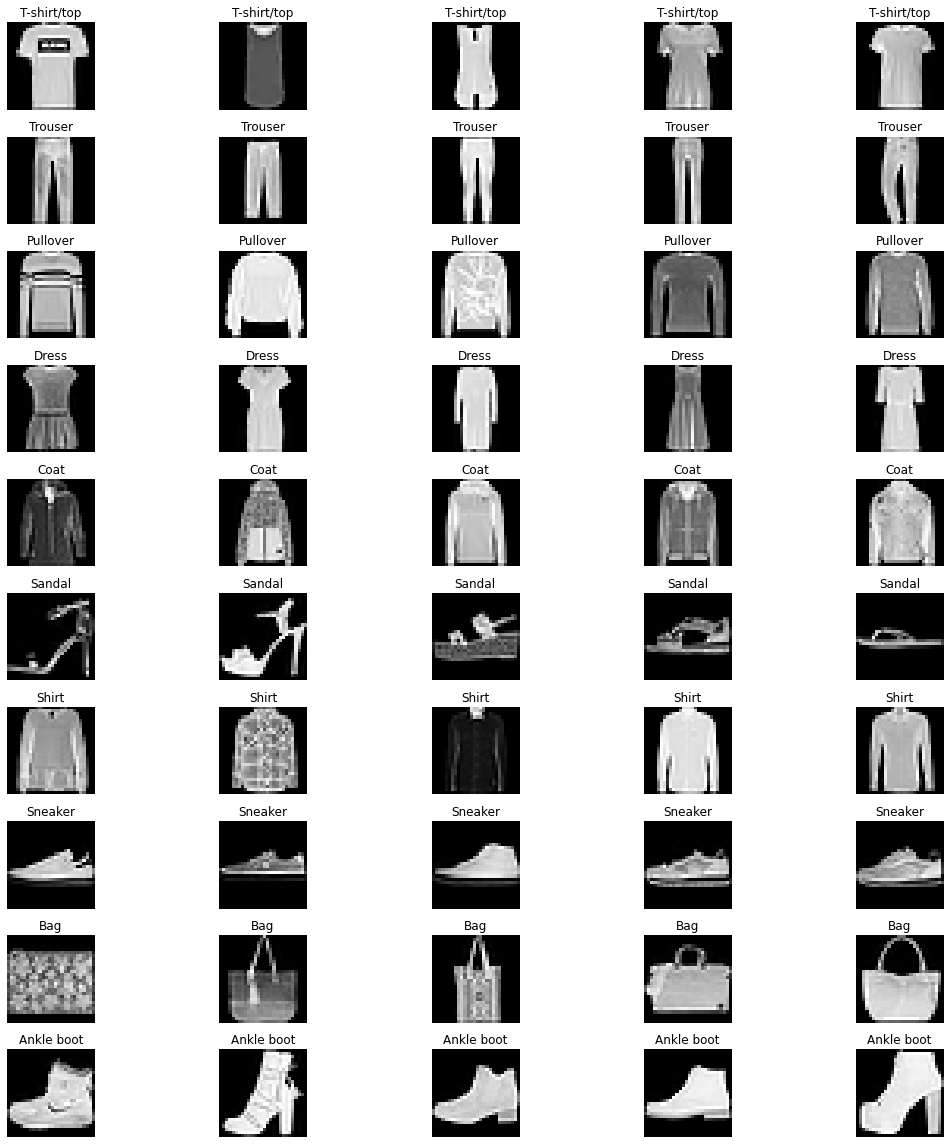

In [ ]:
columns = 5
rows = len(label)
fig = plt.figure(figsize=(16, 16))
idx = 1
for n,lab in enumerate(label):
  lab_list = [j for j,i in enumerate(train_labels) if i==n][:5]
  for k in lab_list:
    fig.add_subplot(rows, columns, idx)
    plt.title(lab)
    plt.imshow(train_images[k][:,:,0], cmap='gray')
    plt.axis('off')
    idx +=1
plt.tight_layout()
plt.show()

#### 2.2 Apply rotation and height shift augmentation (rotation_range, height_shift_range)to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

In [ ]:
train_images_aug = []
datagen = ImageDataGenerator()
for j in range(train_images.shape[0]):
  train_images_aug.append(datagen.apply_transform(train_images[j],transform_parameters={'theta':np.random.randint(low=-45,high=45),'ty':np.random.randint(low=2,high=10)}))
train_images_aug = np.array(train_images_aug)

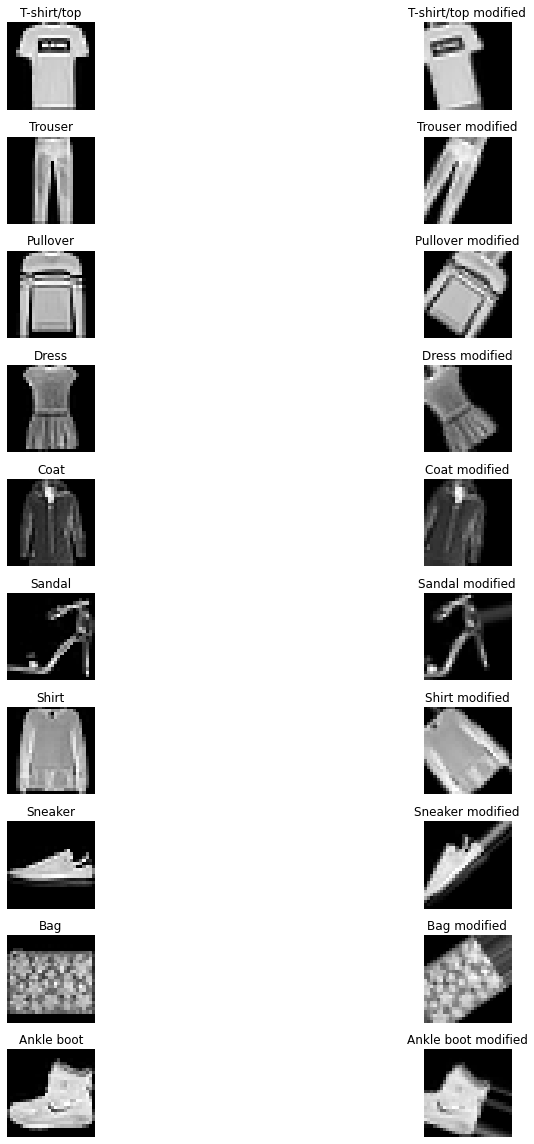

In [ ]:
columns =2
rows = len(label)
fig = plt.figure(figsize=(16, 16))
idx = 1
for n,lab in enumerate(label):
  lab_list = [j for j,i in enumerate(train_labels) if i==n][0]
  fig.add_subplot(rows, columns, idx)
  plt.title(lab)
  plt.imshow(train_images[lab_list][:,:,0], cmap='gray')
  plt.axis('off')
  idx+=1
  fig.add_subplot(rows, columns, idx)
  plt.title(lab+' modified')
  plt.imshow(train_images_aug[lab_list][:,:,0], cmap='gray')
  plt.axis('off')
  idx+=1
plt.tight_layout()
plt.show()

#### 2.3 Bring the train and test data in the required format. 

In [ ]:
test_images_aug = []
for j in range(test_images.shape[0]):
  test_images_aug.append(datagen.apply_transform(test_images[j],transform_parameters={'theta':np.random.randint(low=-45,high=45),'ty':np.random.randint(low=2,high=10)}))
test_images_aug = np.array(test_images_aug)

In [ ]:
train_labels1 = to_categorical(train_labels)
test_labels1 = to_categorical(test_labels)


#### 2.4 Print the shapes of train and test data.

Train data shape

In [ ]:
print("Train data shape: " + str(train_images_aug.shape) +" Train labels: "+str(train_labels.shape[0]))

Train data shape: (60000, 28, 28, 1) Train labels: 60000


Test data shape

In [ ]:
print("Test data shape: " + str(test_images_aug.shape) +" Test labels: "+str(test_labels.shape[0]))

Test data shape: (10000, 28, 28, 1) Test labels: 10000


## 3. Model Building (0.2*5 = 1 mark)

3.1 Sequential Model layers- Use AT LEAST 4 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

### Testing with 4 hidden layers with relu activation on al layers except the final layer. Adding softmax to the final layer since it is a multi class classification problem

In [ ]:
#testing with 6 layers and seeing output
model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
    tf.keras.layers.Dense(10)
])



### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
Optimizer —This is how the model is updated based on the data it sees and its loss function.
Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

Learning Rate: Initializing the Adam learning rate to 0.001 in order to avoid overshooting of the gradient 

In [ ]:
adam = Adam(0.001)
model.compile(optimizer = adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

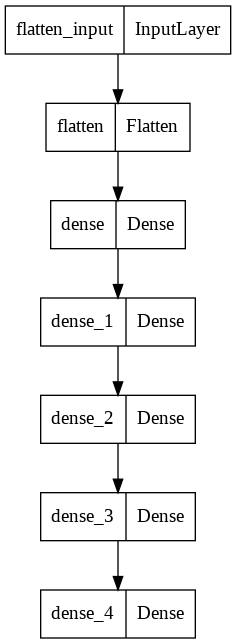

In [ ]:
tf.keras.utils.plot_model(model)

## Train the model

Training the neural network model requires the following steps:

Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
The model learns to associate images and labels.
You ask the model to make predictions about a test set—in this example, the test_images array.
Verify that the predictions match the labels from the test_labels array.

### Feed the model

To start training, call the model.fit method—so called because it "fits" the model to the training data:

In [ ]:
history = model.fit(train_images_aug,train_labels,epochs=10,batch_size=1024,verbose=True,validation_data=(test_images_aug,test_labels))

Epoch 1/10
59/59 [==============================] - 1s 9ms/step - loss: 2.0964 - accuracy: 0.3083 - val_loss: 2.0244 - val_accuracy: 0.3820
Epoch 2/10
59/59 [==============================] - 0s 6ms/step - loss: 1.9862 - accuracy: 0.3883 - val_loss: 1.9502 - val_accuracy: 0.4023
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - loss: 1.9132 - accuracy: 0.4035 - val_loss: 1.8803 - val_accuracy: 0.4184
Epoch 4/10
59/59 [==============================] - 0s 7ms/step - loss: 1.8489 - accuracy: 0.4059 - val_loss: 1.8166 - val_accuracy: 0.4044
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 1.7845 - accuracy: 0.4067 - val_loss: 1.7680 - val_accuracy: 0.3858
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 1.7283 - accuracy: 0.4199 - val_loss: 1.7192 - val_accuracy: 0.4135
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 1.6773 - accuracy: 0.4394 - val_loss: 1.6696 - val_accuracy: 0.4371
Epoch 8/10
59/59 [==

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               401920    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dense_21 (Dense)            (None, 16)                2064      
                                                                 
 dense_22 (Dense)            (None, 10)                170       
                                                                 
Total params: 568,378
Trainable params: 568,378
Non-tr

In [ ]:
train_images_aug.shape

(60000, 28, 28, 1)

In [ ]:
test_labels.shape

(10000,)

It appears that the accuracy of the train and the test set is not as impressive. So switching the softmax activation in the final layer to relu and adding more layers to see if this improves the train-test accuracy

### Testing with 5 hidden layers with relu activation on the final layer and seeing output

In [ ]:


model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10)
    
])

model2.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model2)

history2 = model2.fit(train_images_aug,train_labels,epochs=10,batch_size=1000,verbose=True,validation_data=(test_images_aug,test_labels))



Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 1.3766 - accuracy: 0.4661 - val_loss: 0.9450 - val_accuracy: 0.6481
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8408 - accuracy: 0.6859 - val_loss: 0.7873 - val_accuracy: 0.7058
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7274 - accuracy: 0.7309 - val_loss: 0.7406 - val_accuracy: 0.7183
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6675 - accuracy: 0.7524 - val_loss: 0.7056 - val_accuracy: 0.7399
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6245 - accuracy: 0.7681 - val_loss: 0.6696 - val_accuracy: 0.7495
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.5876 - accuracy: 0.7811 - val_loss: 0.6566 - val_accuracy: 0.7537
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.5601 - accuracy: 0.7911 - val_loss: 0.6346 - val_accuracy: 0.7661
Epoch 8/10
60/60 [==

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 10)               

In [ ]:
model2.evaluate(train_images_aug,train_labels, verbose=False)

[0.469443142414093, 0.8276333212852478]

In [ ]:
model2.evaluate(test_images_aug,test_labels, verbose=False)

[0.6120062470436096, 0.7789000272750854]

### Testing with 6 hidden layers and seeing output

In [ ]:
#testing with 6 layers and seeing output

model6 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10)
])

model6.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model6)

history6 = model6.fit(train_images_aug,train_labels,epochs=10,batch_size=1000,verbose=True,validation_data=(test_images_aug,test_labels))



Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 1.5555 - accuracy: 0.4116 - val_loss: 1.1583 - val_accuracy: 0.5714
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9359 - accuracy: 0.6527 - val_loss: 0.8617 - val_accuracy: 0.6813
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7756 - accuracy: 0.7163 - val_loss: 0.7655 - val_accuracy: 0.7112
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6986 - accuracy: 0.7434 - val_loss: 0.7266 - val_accuracy: 0.7285
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6415 - accuracy: 0.7648 - val_loss: 0.7032 - val_accuracy: 0.7398
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6070 - accuracy: 0.7757 - val_loss: 0.6733 - val_accuracy: 0.7557
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.5731 - accuracy: 0.7883 - val_loss: 0.6580 - val_accuracy: 0.7628
Epoch 8/10
60/60 [==

In [ ]:
model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               401920    
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)               

In [ ]:
model6.evaluate(train_images_aug,train_labels, verbose=False)

[0.47654104232788086, 0.8216333389282227]

In [ ]:
model6.evaluate(test_images_aug,test_labels, verbose=False)

[0.62909334897995, 0.7732999920845032]

### Evaluate accuracy

Next, compare how the model performs on the test dataset with diffrent hidden layers:

In [ ]:
test_loss, test_acc = model.evaluate(test_images_aug,  test_labels, verbose=2)

print('Test accuracy with 4 hidden layers', test_acc)

313/313 - 1s - loss: 0.5977 - accuracy: 0.7888 - 550ms/epoch - 2ms/step
Test accuracy with 4 hidden layers 0.7888000011444092


In [ ]:
test_loss, test_acc = model2.evaluate(test_images_aug,  test_labels, verbose=2)

print('\Test accuracy with 5 hidden layers', test_acc)

313/313 - 1s - loss: 0.6120 - accuracy: 0.7789 - 790ms/epoch - 3ms/step
\Test accuracy with 5 hidden layers 0.7789000272750854


In [ ]:
test_loss, test_acc = model6.evaluate(test_images_aug,  test_labels, verbose=2)

print('\nTest accuracy with 6 hidden layers:', test_acc)

313/313 - 1s - loss: 0.6291 - accuracy: 0.7733 - 661ms/epoch - 2ms/step

Test accuracy with 6 hidden layers: 0.7732999920845032


### Model Selection:
There is only marginal improvement with increase of layers. Also, one with 4 hidden layers is performing better, so going with the less complex model i.e. with 4 hidden layers.

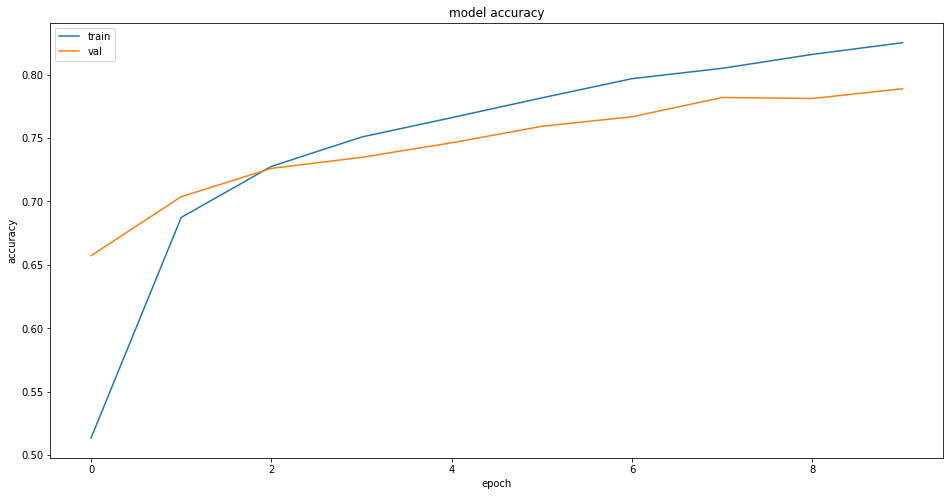

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

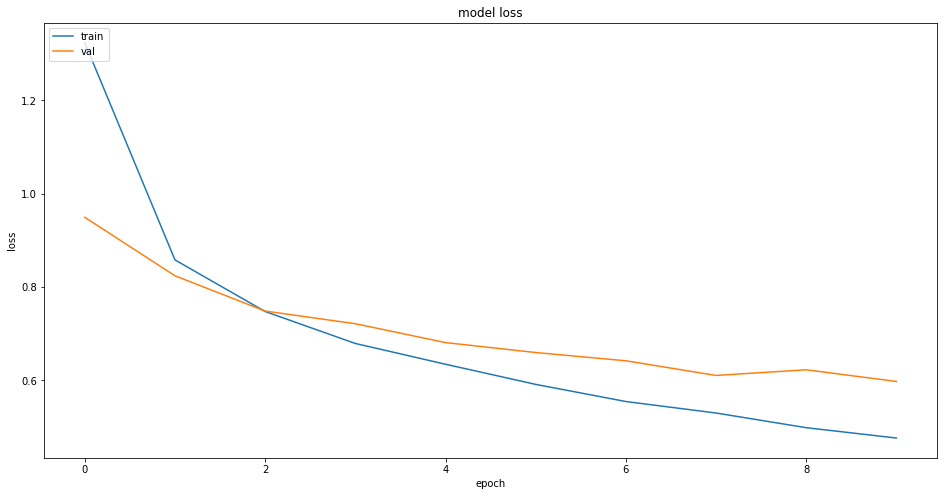

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Observation: Since the training model crosses over testing data close to epoch 2, we can stop the training at 2 to avoid overfitting. However, for this project, we did not stop the epoch for simplicity sake.

## Modifications based on learnings:

Adding L2 regularization to all the layers of the selected model.

Adding one layer of dropout at the layer with the largest number of nodes i.e densest layer. Through hit and trial we found this stratergy to be the best.

We have added ReLU activation function in all the hidden layersas the main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time.

Though this is a multiclass classification problem, when we tried adding softmax as the activation function, the accuracy took a hit. Hence adding relu in the final layer as well

Model on the basis of the above learned parameters have been created below.

In [ ]:
#Testing with 4 layers with above modifications and seeing output

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dense(10)
])



In [ ]:
#Testing with 4 layers with above modifications BUT WITHOUT REGULARIZATION and seeing output

modelZ = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10)
])



Model Compilation

Compiling the model with the appropriate SparseCategoricalCrossentropy loss function with  accuracy as a metric.

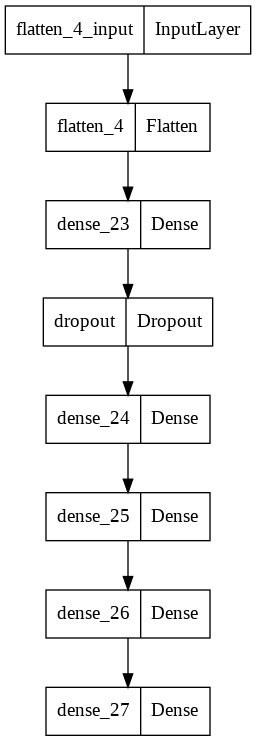

In [ ]:
model.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model)



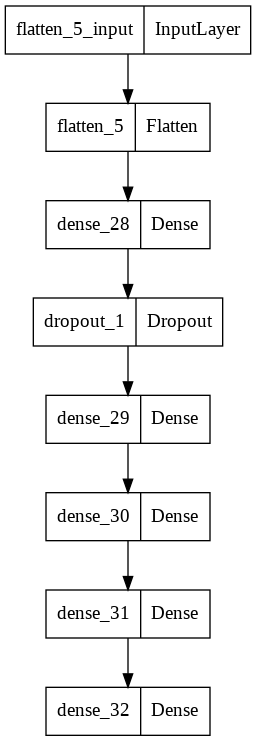

In [ ]:
modelZ.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(modelZ)



## Model Training WITH regularization and WITHOUT regularization

In [ ]:
history = model.fit(train_images_aug,train_labels,epochs=50,batch_size=1024,verbose=True,validation_data=(test_images_aug,test_labels))

Epoch 1/50
59/59 [==============================] - 1s 10ms/step - loss: 2.1864 - accuracy: 0.3766 - val_loss: 1.4135 - val_accuracy: 0.5776
Epoch 2/50
59/59 [==============================] - 0s 7ms/step - loss: 1.3097 - accuracy: 0.6004 - val_loss: 1.1557 - val_accuracy: 0.6476
Epoch 3/50
59/59 [==============================] - 0s 6ms/step - loss: 1.1616 - accuracy: 0.6465 - val_loss: 1.0594 - val_accuracy: 0.6821
Epoch 4/50
59/59 [==============================] - 0s 7ms/step - loss: 1.0863 - accuracy: 0.6675 - val_loss: 1.0131 - val_accuracy: 0.6927
Epoch 5/50
59/59 [==============================] - 0s 6ms/step - loss: 1.0384 - accuracy: 0.6808 - val_loss: 0.9930 - val_accuracy: 0.6948
Epoch 6/50
59/59 [==============================] - 0s 6ms/step - loss: 1.0080 - accuracy: 0.6937 - val_loss: 0.9461 - val_accuracy: 0.7084
Epoch 7/50
59/59 [==============================] - 0s 8ms/step - loss: 0.9802 - accuracy: 0.7002 - val_loss: 0.9274 - val_accuracy: 0.7221
Epoch 8/50
59/59 [=

In [ ]:
historyZ = modelZ.fit(train_images_aug,train_labels,epochs=50,batch_size=1024,verbose=True,validation_data=(test_images_aug,test_labels))

Epoch 1/50
59/59 [==============================] - 1s 12ms/step - loss: 1.7359 - accuracy: 0.3520 - val_loss: 1.2110 - val_accuracy: 0.5441
Epoch 2/50
59/59 [==============================] - 0s 8ms/step - loss: 1.0668 - accuracy: 0.5915 - val_loss: 0.9090 - val_accuracy: 0.6525
Epoch 3/50
59/59 [==============================] - 1s 9ms/step - loss: 0.9096 - accuracy: 0.6546 - val_loss: 0.8095 - val_accuracy: 0.6930
Epoch 4/50
59/59 [==============================] - 0s 6ms/step - loss: 0.8377 - accuracy: 0.6839 - val_loss: 0.7765 - val_accuracy: 0.7057
Epoch 5/50
59/59 [==============================] - 0s 6ms/step - loss: 0.7992 - accuracy: 0.6995 - val_loss: 0.7513 - val_accuracy: 0.7215
Epoch 6/50
59/59 [==============================] - 1s 10ms/step - loss: 0.7672 - accuracy: 0.7111 - val_loss: 0.7220 - val_accuracy: 0.7315
Epoch 7/50
59/59 [==============================] - 1s 9ms/step - loss: 0.7473 - accuracy: 0.7200 - val_loss: 0.7082 - val_accuracy: 0.7369
Epoch 8/50
59/59 [

In [ ]:
test_lossZ, test_accZ = modelZ.evaluate(test_images_aug,  test_labels, verbose=2)

print('Test accuracy with 4 hidden layers WITHOUT REGULARIZATION', test_accZ)

313/313 - 1s - loss: 0.5737 - accuracy: 0.7940 - 553ms/epoch - 2ms/step
Test accuracy with 4 hidden layers WITHOUT REGULARIZATION 0.7940000295639038


In [ ]:
test_loss, test_acc = model.evaluate(test_images_aug,  test_labels, verbose=2)

print('Test accuracy with 4 hidden layers WITH REGULARIZATION', test_acc)

313/313 - 1s - loss: 0.8008 - accuracy: 0.7614 - 606ms/epoch - 2ms/step
Test accuracy with 4 hidden layers WITH REGULARIZATION 0.7613999843597412


## Observation:

There is a slight dip in the performance of the model with regularization as it loses nodes. Howeever, as the perfomance is similar and the diffrence is slight, we will move ahead with the model that uses regularization. 

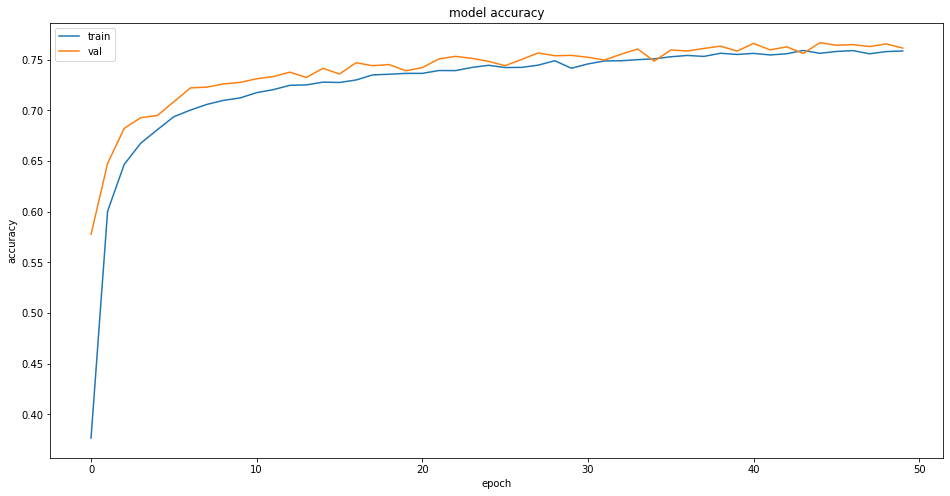

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

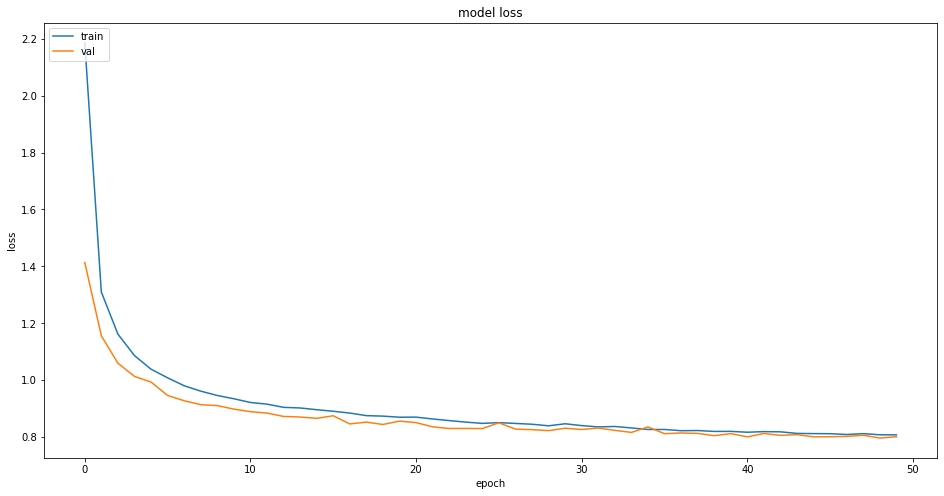

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Print the model summary.

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 16)                2064      
                                                                 
 dense_27 (Dense)            (None, 10)               

Model loss and accuracy on training and validation dataset

In [ ]:
model.evaluate(train_images_aug,train_labels, verbose=False)

[0.7142656445503235, 0.7954166531562805]

In [ ]:
model.evaluate(test_images_aug,test_labels, verbose=False)

[0.8007577657699585, 0.7613999843597412]

In [ ]:
yhat = model.predict(test_images_aug,batch_size=10000)
print("prediction shape:", yhat.shape)

prediction shape: (10000, 10)


In [ ]:
# actual
#y_act = [np.argmax(i) for i in test_labels]

# decoding predicted values
y_hat = [np.argmax(i) for i in yhat]

In [ ]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

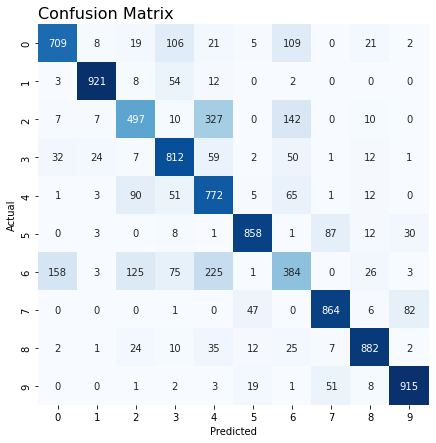

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(test_labels, y_hat), annot=True,  cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix', loc='left', fontsize=16)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(test_labels, y_hat))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1000
           1       0.95      0.92      0.94      1000
           2       0.64      0.50      0.56      1000
           3       0.72      0.81      0.76      1000
           4       0.53      0.77      0.63      1000
           5       0.90      0.86      0.88      1000
           6       0.49      0.38      0.43      1000
           7       0.85      0.86      0.86      1000
           8       0.89      0.88      0.89      1000
           9       0.88      0.92      0.90      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Based on the confusion matrix and the classification report, we can say that the class 1 Trouser is the best performing class, with its high precision, recall and F1 scores being - 0.95, 0.92, 0.94 respectively. 

The worst performing class is 6 Shirt with its precision, recall and F1 score being - 0.49, 0.38, 0.43 respectively

In [ ]:
[i for i,_ in enumerate(test_labels) if test_labels[i]!=y_hat[i]][:15]

[17, 21, 23, 25, 26, 27, 40, 43, 44, 45, 46, 49, 50, 51, 53]

In [ ]:
test_labels[12],y_hat[12]

(7, 7)

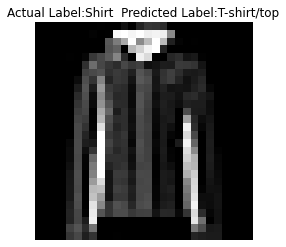

In [ ]:
fig = plt.figure(figsize=(4, 4))

lab_act = label[test_labels[40]]
lab_hat = label[y_hat[40]]
fig.add_subplot(1, 1, 1)
plt.title('Actual Label:'+lab_act+'  Predicted Label:'+lab_hat)
plt.imshow(test_images[test_labels[40]][:,:,0], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

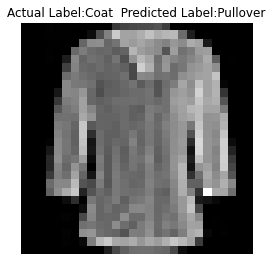

In [ ]:
fig = plt.figure(figsize=(4, 4))

lab_act = label[test_labels[51]]
lab_hat = label[y_hat[51]]
fig.add_subplot(1, 1, 1)
plt.title('Actual Label:'+lab_act+'  Predicted Label:'+lab_hat)
plt.imshow(test_images[test_labels[51]][:,:,0], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()